In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time

In [2]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [3]:
from utils import check_cifar_dataset_exists
data_path=check_cifar_dataset_exists()

train_data=torch.load(data_path+'cifar/train_data.pt')
train_label=torch.load(data_path+'cifar/train_label.pt')
test_data=torch.load(data_path+'cifar/test_data.pt')
test_label=torch.load(data_path+'cifar/test_label.pt')

print(train_data.size())
print(test_data.size())

torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


In [4]:
class Stem(nn.Module):

    def __init__(self):

        super(Stem, self).__init__()
        
        #----------------------- stem block start ----------------------------
        
        #3 x 32 x 32 --> 16 x 30 x 30  , VALID Padding 
        #self.conv1a = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=0 ) 
        
        #3 x 32 x 32 --> 16 x 30 x 30  , VALID Padding 
        self.conv1a = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0 )
        self.bn1a = nn.BatchNorm2d(16,affine=True, eps=0.001,momentum=0.1)
        
        #16 x 30 x 30 --> 32 x 30 x 30  , SAME Padding 
        self.conv1b = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1 )
        self.bn1b = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #======================== Filter concat 1 =============================
        
        #32 x 30 x 30 --> 32 x 28 x 28, kernel size = 3, VALID Padding  
        self.pool1  = nn.MaxPool2d(kernel_size=3, stride=1, padding=0 )
        
        #32 x 30 x 30 --> 48 x 28 x 28  , VALID Padding
        self.conv2a = nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=0 )
        self.bn2a = nn.BatchNorm2d(48,affine=True, eps=0.001,momentum=0.1)
        
        #======================== Filter concat 1 =============================
        
        #======================== Filter concat 2 =============================       
        
        #80 x 28 x 28 --> 32 x 28 x 28  , SAME Padding   
        self.conv3a = nn.Conv2d(80, 32, stride=1, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #32 x 28 x 28 --> 48 x 26 x 26  , VALID Padding   
        self.conv3b = nn.Conv2d(32, 48, stride=1, kernel_size=3, padding=0 )
        self.bn3b = nn.BatchNorm2d(48,affine=True, eps=0.001,momentum=0.1)
        
        #80 x 28 x 28 --> 32 x 28 x 28  , SAME Padding   Might be combined with self.conv1e1
        self.conv4a = nn.Conv2d(80, 32, stride=1, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #32 x 28 x 28 --> 32 x 28 x 28  , SAME Padding   Find out the size of output
        self.conv4b = nn.Conv2d(32, 32, stride=1, kernel_size=[7,1], padding=[3,0] )
        self.bn4b = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #32 x 28 x 28 --> 32 x 28 x 28  , SAME Padding   Find out the size of output
        self.conv4c = nn.Conv2d(32, 32, stride=1, kernel_size=[1,7], padding=[0,3] )
        self.bn4c = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #32 x 28 x 28 --> 48 x 26 x 26  , VALID Padding   Might be combined with self.conv1e2
        self.conv4d = nn.Conv2d(32, 48, stride=1, kernel_size=3, padding=0 )
        self.bn4d = nn.BatchNorm2d(48,affine=True, eps=0.001,momentum=0.1)
        
        #======================== Filter concat 2 ============================= 
        
        #======================== Filter concat 3 =============================
        
        #96 x 26 x 26 --> 192 x 26 x 26  , SAME Padding 
        self.conv5a = nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1 )
        self.bn5a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
         
        #192 x 71 x 71 --> 192 x 35 x 35, kernel size = 3, VALID Padding
        #self.pool2  = nn.MaxPool2d(3, stride=2, padding=0 )
        
        #======================== Filter concat 3 =============================
        
        #----------------------- stem block finish ----------------------------
        
    def forward(self, x):

        # block 1: 
        x = self.conv1a(x)
        x = self.bn1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = F.relu(x)
        #x = self.conv1c(x)
        #x = F.relu(x)
        
        xP = self.pool1(x)
        xC = self.conv2a(x)
        x = self.bn2a(xC)
        xC = F.relu(xC)
        xFC1 = torch.cat((xP, xC), 1)
       
        y = self.conv3a(xFC1)
        y = self.bn3a(y)
        y = F.relu(y)
        y = self.conv3b(y)
        y = self.bn3b(y)
        y = F.relu(y)
       
        z = self.conv4a(xFC1)
        z = self.bn4a(z)
        z = F.relu(z)
        z = self.conv4b(z)
        z = self.bn4b(z)
        z = F.relu(z)
        z = self.conv4c(z)
        z = self.bn4c(z)
        z = F.relu(z)
        z = self.conv4d(z)
        z = self.bn4d(z)
        z = F.relu(z)
        
        # Above code or this one?
        #z = self.conv3a(xFC1)
        #z = F.relu(z)
        #z = self.conv4b(z)
        #z = F.relu(z)
        #z = self.conv4c(xFC1)
        #z = F.relu(z)
        #z = self.conv3b(z)
        #z = F.relu(z)
        
        xFC2 = torch.cat((y, z), 1)
        
        #xP = self.pool2(xFC2)
        xC = self.conv5a(xFC2)
        xC = self.bn5a(xC)
        xC = F.relu(xC)
        #xFC3 = torch.cat((xP, xC), 1)   
        
        return xC

In [5]:
class InceptionA(nn.Module):

    def __init__(self):

        super(InceptionA, self).__init__()
        
        #----------------------- InceptionA block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #192 x 26 x 26 --> 192 x 26 x 26  , kernel size = 3, SAME Padding
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1 )
        
        #192 x 26 x 26 --> 48 x 26 x 26  , SAME Padding 
        self.conv1a = nn.Conv2d(192, 48, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(48,affine=True, eps=0.001,momentum=0.1)
        
        #block 2
        #192 x 26 x 26 --> 48 x 26 x 26  , SAME Padding 
        self.conv2a = nn.Conv2d(192, 48, kernel_size=1, padding=0 ) 
        self.bn2a = nn.BatchNorm2d(48,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #192 x 26 x 26 --> 32 x 26 x 26  , SAME Padding 
        self.conv3a = nn.Conv2d(192, 32, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)
        
        #32 x 26 x 26 --> 48 x 26 x 26  , SAME Padding 
        self.conv3b = nn.Conv2d(32, 48, kernel_size=3, padding=1 )
        self.bn3b = nn.BatchNorm2d(48,affine=True, eps=0.001,momentum=0.1)
        
        #block 4
        #192 x 26 x 26 --> 32 x 26 x 26  , SAME Padding 
        self.conv4a = nn.Conv2d(192, 32, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(32,affine=True, eps=0.001,momentum=0.1)

        #32 x 26 x 26 --> 48 x 26 x 26  , SAME Padding 
        self.conv4b = nn.Conv2d(32, 48, kernel_size=3, padding=1 )
        self.bn4b = nn.BatchNorm2d(48,affine=True, eps=0.001,momentum=0.1)
        
        #48 x 26 x 26 --> 48 x 26 x 26  , SAME Padding 
        self.conv4c = nn.Conv2d(48, 48, kernel_size=3, padding=1 )
        self.bn4c = nn.BatchNorm2d(48,affine=True, eps=0.001,momentum=0.1)
        
        
        #======================== Filter concat =============================
        
        #----------------------- InceptionA block finish ----------------------------
        
    def forward(self, x):

        # block 1:
        y = self.pool1(x)
        y = self.conv1a(y)
        y = self.bn1a(y)
        y = F.relu(y)   # Do we need Relu here (after last operation)?
        
        # block 2:
        z = self.conv2a(x)
        z = self.bn2a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv3a(x)
        w = self.bn3a(w)
        w = F.relu(w)
        w = self.conv3b(w)
        w = self.bn3b(w)
        w = F.relu(w)
        
        #block 4:
        v = self.conv4a(x)
        v = self.bn4a(v)
        v = F.relu(v)
        v = self.conv4b(v)
        v = self.bn4b(v)
        v = F.relu(v)
        v = self.conv4c(v)
        v = self.bn4c(v)
        v = F.relu(v)
        
        xFC = torch.cat((y, z, w, v), 1)
        #print('InceptionA Done')
        
        return xFC

In [6]:
class InceptionB(nn.Module):

    def __init__(self):

        super(InceptionB, self).__init__()
        
        #----------------------- InceptionB block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #512 x 12 x 12 --> 512 12 x 12  , kernel size = 1, SAME Padding
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1 )
        
        #512 x 12 x 12 --> 64 x 12 x 12  , SAME Padding 
        self.conv1a = nn.Conv2d(512, 64, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(64,affine=True, eps=0.001,momentum=0.1)
        
        #block 2
        #512 x 12 x 12 --> 192 x 12 x 12  , SAME Padding 
        self.conv2a = nn.Conv2d(512, 192, kernel_size=1, padding=0 ) 
        self.bn2a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #512 x 12 x 12 --> 96 x 12 x 12  , SAME Padding 
        self.conv3a = nn.Conv2d(512, 96, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #96 x 12 x 12 --> 112 x 12 x 12  , SAME Padding 
        self.conv3b = nn.Conv2d(96, 112, kernel_size=[7,1], padding=[3,0] )
        self.bn3b = nn.BatchNorm2d(112,affine=True, eps=0.001,momentum=0.1)
        
        #112 x 12 x 12 --> 128 x 12 x 12  , SAME Padding 
        self.conv3c = nn.Conv2d(112, 128, kernel_size=[1,7], padding=[0,3] )
        self.bn3c = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #block 4
        #512 x 12 x 12 --> 96 x 12 x 12  , SAME Padding 
        self.conv4a = nn.Conv2d(512, 96, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #96 x 12 x 12 --> 96 x 12 x 12  , SAME Padding 
        self.conv4b = nn.Conv2d(96, 96, kernel_size=[1,7], padding=[0,3] )
        self.bn4b = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #96 x 12 x 12 --> 112 x 12 x 12  , SAME Padding 
        self.conv4c = nn.Conv2d(96, 112, kernel_size=[7,1], padding=[3,0] )
        self.bn4c = nn.BatchNorm2d(112,affine=True, eps=0.001,momentum=0.1)
        
        #112 x 12 x 12 --> 112 x 12 x 12  , SAME Padding 
        self.conv4d = nn.Conv2d(112, 112, kernel_size=[1,7], padding=[0,3] )
        self.bn4d = nn.BatchNorm2d(112,affine=True, eps=0.001,momentum=0.1)
        
        #112 x 12 x 12 --> 128 x 12 x 12  , SAME Padding 
        self.conv4e = nn.Conv2d(112, 128, kernel_size=[7,1], padding=[3,0] )
        self.bn4e = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        
        #======================== Filter concat =============================
        
        #----------------------- InceptionB block finish ----------------------------
        
    def forward(self, x):
        
        # block 1:
        y = self.pool1(x)
        y = self.conv1a(y)
        y = self.bn1a(y)
        y = F.relu(y)
        
        # block 2:
        z = self.conv2a(x)
        z = self.bn2a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv3a(x)
        w = self.bn3a(w)
        w = F.relu(w)
        w = self.conv3b(w)
        w = self.bn3b(w)
        w = F.relu(w)
        w = self.conv3c(w)
        w = self.bn3c(w)
        w = F.relu(w)
        
        #block 4:
        v = self.conv4a(x)
        v = self.bn4a(v)
        v = F.relu(v)
        v = self.conv4b(v)
        v = self.bn4b(v)
        v = F.relu(v)
        v = self.conv4c(v)
        v = self.bn4c(v)
        v = F.relu(v)
        v = self.conv4d(v)
        v = self.bn4d(v)
        v = F.relu(v)
        v = self.conv4e(v)
        v = self.bn4e(v)
        v = F.relu(v)
        
        xFC = torch.cat((y, z, w, v), 1)
        #print('InceptionB Done')
        
        return xFC

In [7]:
class InceptionC(nn.Module):

    def __init__(self):

        super(InceptionC, self).__init__()
        
        #----------------------- InceptionC block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #768 x 5 x 5 --> 768 x 5 x 5  , kernel size = 3, SAME Padding
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1 )
        
        #768 x 5 x 5 --> 128 x 5 x 5  , SAME Padding 
        self.conv1a = nn.Conv2d(768, 128, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #block 2
        #768 x 5 x 5 --> 128 x 5 x 5  , SAME Padding 
        self.conv2a = nn.Conv2d(768, 128, kernel_size=1, padding=0 ) 
        self.bn2a = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #768 x 5 x 5 --> 192 x 5 x 5  , SAME Padding 
        self.conv3a = nn.Conv2d(768, 192, kernel_size=1, padding=0 )
        self.bn3a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 5 x 5 --> 128 x 5 x 5  , SAME Padding 
        self.conv3b = nn.Conv2d(192, 128, kernel_size=[1,3], padding=[0,1] )
        self.bn3b = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 5 x 5 --> 128 x 5 x 5  , SAME Padding 
        self.conv3c = nn.Conv2d(192, 128, kernel_size=[3,1], padding=[1,0] )
        self.bn3c = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #block 4
        #768 x 5 x 5--> 192 x 5 x 5  , SAME Padding 
        self.conv4a = nn.Conv2d(768, 192, kernel_size=1, padding=0 )
        self.bn4a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #192 x 5 x 5 --> 224 x 5 x 5  , SAME Padding 
        self.conv4b = nn.Conv2d(192, 224, kernel_size=[1,3], padding=[0,1] )
        self.bn4b = nn.BatchNorm2d(224,affine=True, eps=0.001,momentum=0.1)
        
        #224 x 5 x 5 --> 256 x 5 x 5  , SAME Padding 
        self.conv4c = nn.Conv2d(224, 256, kernel_size=[3,1], padding=[1,0] )
        self.bn4c = nn.BatchNorm2d(256,affine=True, eps=0.001,momentum=0.1)
        
        #256 x 5 x 5 --> 128 x 5 x 5  , SAME Padding 
        self.conv4d = nn.Conv2d(256, 128, kernel_size=[3,1], padding=[1,0])
        self.bn4d = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #256 x 5 x 5 --> 128 x 5 x 5  , SAME Padding 
        self.conv4e = nn.Conv2d(256, 128, kernel_size=[1,3], padding=[0,1] )
        self.bn4e = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        
        #======================== Filter concat =============================
        
        #----------------------- InceptionC block finish ----------------------------
        
    def forward(self, x):
        
        # block 1:
        y = self.pool1(x)
        y = self.conv1a(y)
        y = self.bn1a(y)
        y = F.relu(y)
        
        # block 2:
        z = self.conv2a(x)
        z = self.bn2a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv3a(x)
        w = self.bn3a(w)
        w = F.relu(w)
        w1 = self.conv3b(w)
        w1 = self.bn3b(w1)
        w1 = F.relu(w1)
        w2 = self.conv3c(w)
        w2 = self.bn3c(w2)
        w2 = F.relu(w2)
        
        #block 4:
        v = self.conv4a(x)
        v = self.bn4a(v)
        v = F.relu(v)
        v = self.conv4b(v)
        v = self.bn4b(v)
        v = F.relu(v)
        v = self.conv4c(v)
        v = self.bn4c(v)
        v = F.relu(v)
        v1 = self.conv4d(v)
        v1 = self.bn4d(v1)
        v1 = F.relu(v1)
        v2 = self.conv4e(v)
        v2 = self.bn4e(v2)
        v2 = F.relu(v2)
        
        xFC = torch.cat((y, z, w1, w2, v1, v2), 1)
        
        return xFC

In [8]:
class ReductionA(nn.Module):

    def __init__(self):

        super(ReductionA, self).__init__()
        
        #----------------------- ReductionA block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #192 x 26 x 26 --> 192 x 12 x 12  , kernel size = 3, VALID Padding
        self.pool1  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #block 2
        #192 x 26 x 26 --> 192 x 12 x 12  , VALID Padding -- 
        self.conv1a = nn.Conv2d(192, 192, kernel_size=3, stride=2, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(192,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #192 x 26 x 26 --> 96 x 26 x 26  , SAME Padding 
        self.conv2a = nn.Conv2d(192, 96, kernel_size=1, padding=0 )
        self.bn2a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #96 x 26 x 26 --> 112 x 26 x 26  , SAME Padding 
        self.conv2b = nn.Conv2d(96, 112, kernel_size=3, padding=1 )
        self.bn2b = nn.BatchNorm2d(112,affine=True, eps=0.001,momentum=0.1)
        
        #112 x 26 x 26 --> 128 x 12 x 12  , VALID Padding 
        self.conv2c = nn.Conv2d(112, 128, kernel_size=3, stride=2, padding=0 )
        self.bn2c = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
                
        #======================== Filter concat =============================
        
        #----------------------- ReductionA block finish ----------------------------
        
    def forward(self, x):

        # block 1:
        y = self.pool1(x)
        
        # block 2:
        z = self.conv1a(x)
        z = self.bn1a(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv2a(x)
        w = self.bn2a(w)
        w = F.relu(w)
        w = self.conv2b(w)
        w = self.bn2b(w)
        w = F.relu(w)
        w = self.conv2c(w)
        w = self.bn2c(w)
        w = F.relu(w)
                
        xFC = torch.cat((y, z, w), 1)
        
        return xFC

In [9]:
class ReductionB(nn.Module):

    def __init__(self):

        super(ReductionB, self).__init__()
        
        #----------------------- ReductionB block start ----------------------------
        
        #======================== Filter concat =============================
        
        #block 1
        #512 x 12 x 12 --> 512 x 5 x 5  , kernel size = 3, VALID Padding
        self.pool1  = nn.MaxPool2d(kernel_size=3, stride=2, padding=0 )
        
        #block 2
        #512 x 12 x 12 --> 96 x 12 x 12  , SAME Padding -- 
        self.conv1a = nn.Conv2d(512, 96, kernel_size=1, padding=0 ) 
        self.bn1a = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #96 x 12 x 12 --> 96 x 5 x 5  , VALID Padding -- 
        self.conv1b = nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=0 ) 
        self.bn1b = nn.BatchNorm2d(96,affine=True, eps=0.001,momentum=0.1)
        
        #block 3
        #512 x 12 x 12 --> 128 x 12 x 12  , SAME Padding 
        self.conv2a = nn.Conv2d(512, 128, kernel_size=1, padding=0 )
        self.bn2a = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #128 x 12 x 12 --> 128 x 12 x 12  , SAME Padding 
        self.conv2b = nn.Conv2d(128, 128, kernel_size=[1, 7], padding=[0,3] )
        self.bn2b = nn.BatchNorm2d(128,affine=True, eps=0.001,momentum=0.1)
        
        #128 x 12 x 12 --> 160 x 12 x 12  , SAME Padding 
        self.conv2c = nn.Conv2d(128, 160, kernel_size=[7, 1], padding=[3,0] )
        self.bn2c = nn.BatchNorm2d(160,affine=True, eps=0.001,momentum=0.1)
        
        #160 x 12 x 12 --> 160 x 5 x 5  , VALID Padding 
        self.conv2d = nn.Conv2d(160, 160, kernel_size=3, stride=2, padding=0 )
        self.bn2d = nn.BatchNorm2d(160,affine=True, eps=0.001,momentum=0.1)
                
        #======================== Filter concat =============================
        
        #----------------------- ReductionB block finish ----------------------------
        
    def forward(self, x):

        # block 1:
        y = self.pool1(x)
        
        # block 2:
        z = self.conv1a(x)
        z = self.bn1a(z)
        z = F.relu(z) 
        z = self.conv1b(z)
        z = self.bn1b(z)
        z = F.relu(z) 
        
        #block 3:
        w = self.conv2a(x)
        w = self.bn2a(w)
        w = F.relu(w)
        w = self.conv2b(w)
        w = self.bn2b(w)
        w = F.relu(w)
        w = self.conv2c(w)
        w = self.bn2c(w)
        w = F.relu(w)
        w = self.conv2d(w)
        w = self.bn2d(w)
        w = F.relu(w)
                
        xFC = torch.cat((y, z, w), 1)
        
        return xFC

In [10]:
class Inception_v4_convnet(nn.Module):

    def __init__(self):

        super(Inception_v4_convnet, self).__init__()
        

        # Special attributs
        self.input_space = None
        self.input_size = (32, 32, 3)
        self.num_classes = 1000;

        # Modules
        self.features = nn.Sequential(
            Stem(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            ReductionA(), 
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            ReductionB(), 
            InceptionC(),
            InceptionC(),
            InceptionC()
        )
        
        self.pool = nn.AvgPool2d(kernel_size=5, stride=1, padding=0 )
        self.linear = nn.Linear(768, 10)
        self.dropout = nn.Dropout(0.2) 

    def forward(self, input):
        x = self.features(input)
        
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [11]:
net=Inception_v4_convnet()

print(net)
utils.display_num_param(net)

Inception_v4_convnet(
  (features): Sequential(
    (0): Stem(
      (conv1a): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (bn1a): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv1b): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1b): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (pool1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv2a): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
      (bn2a): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3a): Conv2d(80, 32, kernel_size=(1, 1), stride=(1, 1))
      (bn3a): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3b): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
      (bn3b): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (conv4a): Conv2d(80, 32, k

In [12]:
net = net.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
my_lr=0.01 
bs= 100

In [14]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #inputs = (minibatch_data - mean)/std    # ONLY CHANGE IS HERE!
        
        inputs = minibatch_data

        scores=net( inputs ) 

        error = utils.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

In [15]:
start=time.time()

for epoch in range(1,30):
    
    if not epoch%5:
        my_lr = my_lr / 2
        
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        #inputs = (minibatch_data - mean)/std      # ONLY CHANGE IS HERE!
        
        inputs = minibatch_data
        
        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        

        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    

epoch= 1 	 time= 2.068599232037862 min 	 lr= 0.01 	 loss= 2.0313381154537202 	 error= 77.23600071668625 percent
error rate on test set = 66.34000051021576 percent
 
epoch= 2 	 time= 4.254257726669311 min 	 lr= 0.01 	 loss= 1.6183126668930055 	 error= 59.90600101947784 percent
error rate on test set = 52.84000098705292 percent
 
epoch= 3 	 time= 6.438330550988515 min 	 lr= 0.01 	 loss= 1.3722742655277251 	 error= 49.7540009021759 percent
error rate on test set = 46.87000095844269 percent
 
epoch= 4 	 time= 8.619998927911123 min 	 lr= 0.01 	 loss= 1.1964349547624589 	 error= 42.90600115060806 percent
error rate on test set = 41.36000108718872 percent
 
epoch= 5 	 time= 10.800750720500947 min 	 lr= 0.005 	 loss= 1.0229569079875946 	 error= 36.170001482963556 percent
error rate on test set = 37.76000154018402 percent
 
epoch= 6 	 time= 12.982594613234202 min 	 lr= 0.005 	 loss= 0.9460993807315826 	 error= 33.35400153398514 percent
error rate on test set = 35.420001447200775 percent
 
epoch

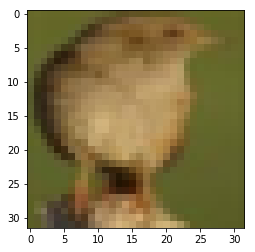

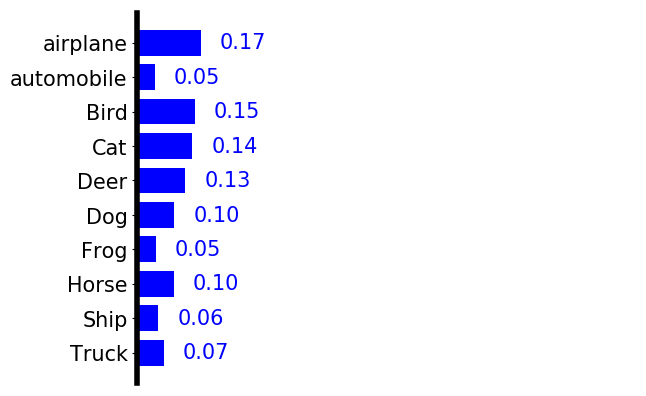

In [16]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1 
im = im.to(device)
#im= (im-mean) / std
im=im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
utils.show_prob_cifar(probs.cpu())